# 네이버 영화 리뷰 데이터 (nsmc) 감성 분석 - LSTM,RNN,GRU

* Dataset   
    *   네이버 영화 리뷰 데이터 (naver sentiment movie corpus)
<table align="left">
  <td>
    <a target="_blank" href="https://github.com/e9t/nsmc">네이버 영화 리뷰 데이터</a>
  </td>
</table>
    



## 라이브러리 불러오기



*   모델 적용할 경우 필요한 라이브러리를 불러옵니다

    *   시각화: matplotlib,seaborn
    *   모델링: pandas,numpy,tensorflow

* 한국어 형태소 분리를 위해 Okt 적용하였습니다.
* 단어 사전을 만들기 위해서 파이썬 Counter 라이브러리 사용하였습니다.
* 분석을 위해 sklearn 라이브러리 사용하였습니다.



In [1]:
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    

In [2]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 42.5 MB/s eta 0:00:00


In [3]:
# 모델링
import pandas as pd
import numpy as np
import tensorflow as tf

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn과 Counter 라이브러리
from collections import Counter
from sklearn.model_selection import train_test_split


# 한국어 형태소 Okt
from konlpy.tag import Okt

## 데이터 불러오기

* train과 test 데이터셋



In [4]:
train = pd.read_table("/content/ratings_train.txt")
test = pd.read_table("/content/ratings_test.txt")


In [5]:
train.head()
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")
train.columns

train shape => (150000, 3) 
test shape => (50000, 3)


Index(['id', 'document', 'label'], dtype='object')

## 시각화

* Seaborn의 countplot과 matplotlib의 pie chart를 적용하여 train과 test 개수를 확인 가능합니다

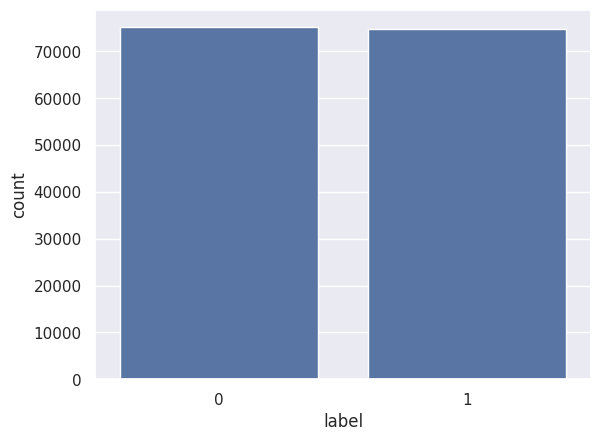

In [7]:
sns.set_theme(style = "darkgrid")
ax = sns.countplot(x = 'label',data = train)

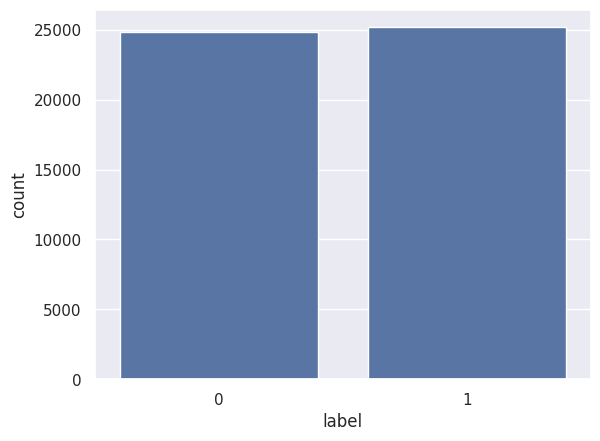

In [8]:
sns.set_theme(style = "darkgrid")
ax = sns.countplot(x = 'label',data = test)

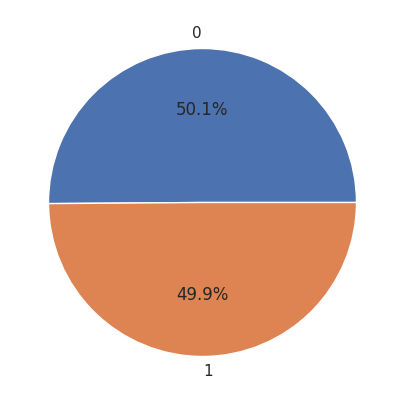

In [9]:
labels,frequencies = np.unique(train.label.values, return_counts = True)
plt.figure(figsize=(5,5))
plt.pie(frequencies,labels= labels,autopct ='%1.1f%%')
plt.show()

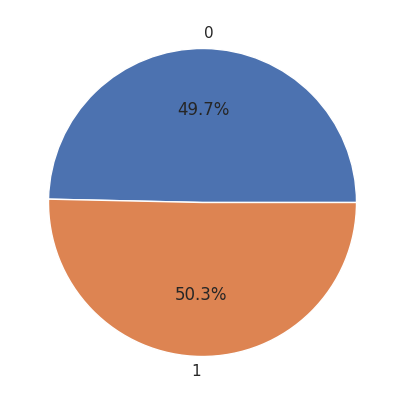

In [10]:
labels,frequencies = np.unique(test.label.values, return_counts = True)
plt.figure(figsize=(5,5))
plt.pie(frequencies,labels= labels,autopct ='%1.1f%%')
plt.show()

- 라벨 값이 균등하게 train과 test에서 확인할 수 있습니다.

## 결과 값 확인



In [11]:
#학습 데이터의 결측 값
train.isnull().sum()


id          0
document    5
label       0
dtype: int64

In [12]:
# test 데이터의 결측 값
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

## 데이터 전처리



*   데이터 중복 제거 (drop_duplicate)
*   결측 값 제거 (dropna)
*   한국어만 추출 (정규표현식 사용)
*   한국어 토큰화 (Okt)
*   불용어 제거 (조사,구두점,접미사 종류)
*   데이터에 정수 인코딩 (text_to_sequence)
*   문장 길이 분포와 적절한 최대 문장 길이 지정
*   최대 문자 길이에 따른 패딩 추가 (pad_sequences)




In [13]:
# 중복값 제거
train.drop_duplicates(subset =['document'],inplace=True)
test.drop_duplicates(subset = ['document'],inplace=True)
print(train)
print(test)

              id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[146183 rows x 3 columns]
            id                                           document  label


In [14]:
    #결측값 제거
    train = train.dropna()
    test = test.dropna()
    print(train)
    print(test)

              id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[146182 rows x 3 columns]
            id                                           document  label


In [15]:
# 한국어만 추출
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'].replace('', np.nan, inplace=True)

test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'].replace('', np.nan, inplace=True)


<ipython-input-15-90b5bd3cf335>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-15-90b5bd3cf335>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['document'].replace('', np.nan, inplace=True)
<ipython-input-15-90b5bd3cf335>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [16]:
# 한국어 토큰화
okt = Okt()

# 불용어 제거
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

# 토큰화 적용
train['tokenized'] = train['document'].apply(okt.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [17]:
test['tokenized'] = test['document'].apply(okt.morphs)
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [18]:
X_train = train['tokenized']
y_train = train['label']
X_test= test['tokenized']
y_test = test['label']

In [19]:
# print(X_train)
# print(y_train)
# print(X_test)
# print(y_test)


# X_train = pd.DataFrame(X_train)
# X_train.to_csv('train_tokenized.csv')
# y_train.to_csv('train_label.csv')
# X_test.to_csv('test_tokenized.csv',encoding='utf-8-sig')
# y_test.to_csv('test_label.csv')




In [20]:

file_path = 'train_tokenized.csv'
data = pd.read_csv(file_path)
data

FileNotFoundError: [Errno 2] No such file or directory: 'train_tokenized.csv'

In [21]:
# 문자열 데이터를 빈도수 기준으로 단어 집합을 생성
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 맵핑하는 함수 text_to_sequences 적용
X_train_sequence= tokenizer.texts_to_sequences(X_train)

In [22]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



단어 집합(vocabulary)의 크기 : 104137
등장 빈도가 1번 이하인 희귀 단어의 수: 56699
단어 집합에서 희귀 단어의 비율: 54.446546376408
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1012428709810984


In [23]:
# 일반적으로 0번 토큰(padding)과 1번 토큰 (OOV)를 피하기 위해 2부터 시작
vocab_size = total_cnt- rare_cnt +2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 47440


In [24]:
X_val= tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 93
리뷰의 평균 길이 : 12.506786061211367


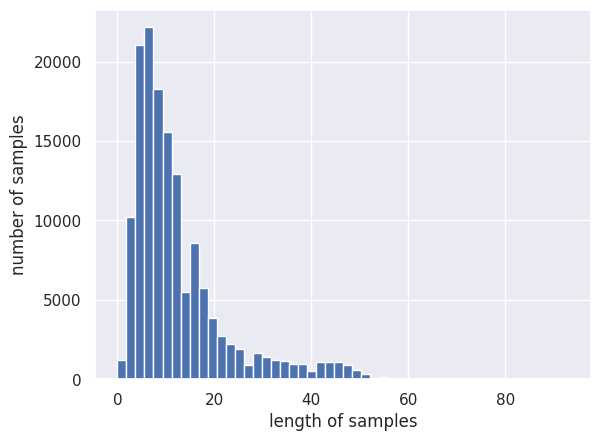

In [25]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 80 #Padding 80으로
X_train = pad_sequences(X_train_sequence, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)

sum =0
for i in X_train:
    sum+=1
print(sum)

146182


In [27]:
y_train

0         0
1         1
2         0
3         0
4         1
         ..
149995    0
149996    1
149997    0
149998    1
149999    0
Name: label, Length: 146182, dtype: int64

## GRU 모델 이용한 감성 분석



In [28]:
#필용한 라이브러리 불러옵니다
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [29]:
# GRU 모델을 적용
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
import tensorflow
tensorflow.__version__

'2.16.1'

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_GRU = model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2)

Epoch 1/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 204s 171ms/step - acc: 0.7797 - loss: 0.4532 - val_acc: 0.8626 - val_loss: 0.3260
Epoch 2/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 201s 170ms/step - acc: 0.9013 - loss: 0.2460 - val_acc: 0.8620 - val_loss: 0.3278
Epoch 3/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 198s 169ms/step - acc: 0.9345 - loss: 0.1708 - val_acc: 0.8557 - val_loss: 0.3753
Epoch 4/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 215s 181ms/step - acc: 0.9559 - loss: 0.1190 - val_acc: 0.8476 - val_loss: 0.4245
Epoch 5/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 209s 179ms/step - acc: 0.9683 - loss: 0.0845 - val_acc: 0.8429 - val_loss: 0.5449
Epoch 6/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 209s 178ms/step - acc: 0.9775 - loss: 0.0606 - val_acc: 0.8420 - val_loss: 0.6361
Epoch 7/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 269s 185ms/step - acc: 0.9833 - loss: 0.0448 - val_acc: 0.8324 - val_loss: 0.7394
Epoch 8/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 258s 182ms/step - acc: 0.9876 - loss: 0.0329 - val_acc: 0.8347 - val_loss: 0.7856
Epoch 9/

## LSTM 모델을 이용한 감성 분석

In [33]:
# LSTM 모델을 적용
from tensorflow.keras.layers import LSTM, Bidirectional

In [34]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 100))
model_lstm.add(LSTM(100)) #Bidirectional drop
model_lstm.add(Dense(1, activation='sigmoid')) #activation = sigmoid -> relu

In [35]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_LSTM = model_lstm.fit(X_train, y_train, epochs=15, batch_size=60, validation_split=0.2)

Epoch 1/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 231s 117ms/step - accuracy: 0.7914 - loss: 0.4333 - val_accuracy: 0.8616 - val_loss: 0.3212
Epoch 2/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 221s 113ms/step - accuracy: 0.9011 - loss: 0.2406 - val_accuracy: 0.8653 - val_loss: 0.3291
Epoch 3/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 257s 111ms/step - accuracy: 0.9337 - loss: 0.1690 - val_accuracy: 0.8591 - val_loss: 0.3674
Epoch 4/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 216s 111ms/step - accuracy: 0.9562 - loss: 0.1155 - val_accuracy: 0.8535 - val_loss: 0.4447
Epoch 5/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 218s 112ms/step - accuracy: 0.9700 - loss: 0.0787 - val_accuracy: 0.8425 - val_loss: 0.5290
Epoch 6/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 218s 112ms/step - accuracy: 0.9791 - loss: 0.0558 - val_accuracy: 0.8454 - val_loss: 0.6442
Epoch 7/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 260s 111ms/step - accuracy: 0.9834 - loss: 0.0440 - val_accuracy: 0.8432 - val_loss: 0.7512
Epoch 8/15
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 263s 112ms/step - ac

## Test 데이터셋에 모델 평가



*   loss 값과 accuracy값이 출력



In [56]:
# Check types
print(type(X_test), type(y_test))

# Convert lists to NumPy arrays if necessary
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verify shapes
print(X_test.shape, y_test.shape)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(49157,) (49157,)


In [60]:
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)

ValueError: setting an array element with a sequence.

In [39]:
history_dict_LSTM = history_LSTM.history
print(history_dict_LSTM.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


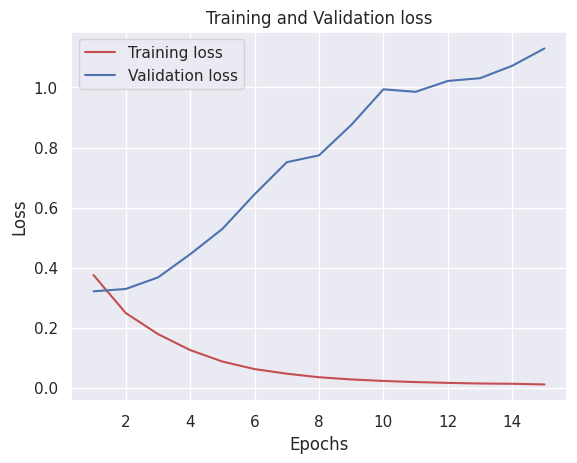

In [41]:
acc = history_dict_LSTM['accuracy']
val_acc = history_dict_LSTM['val_accuracy']
loss = history_dict_LSTM['loss']
val_loss =history_dict_LSTM['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss, 'r', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

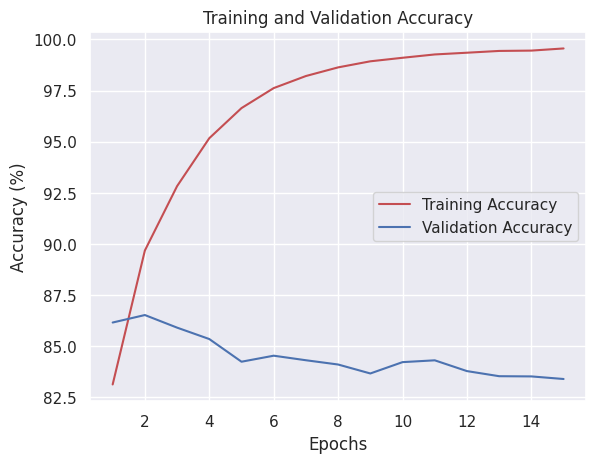

In [68]:
acc = [val *100 for val in history_dict_LSTM['accuracy']]
val_acc = [val *100 for val in history_dict_LSTM['val_accuracy']]

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [52]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [54]:
#GRU로 학습된 모델로 평가
predict_GRU = model.evaluate(X_test,y_test,verbose=1)
print(predict_GRU)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [44]:
history_dict_GRU = history_GRU.history
print(history_dict_GRU.keys())

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


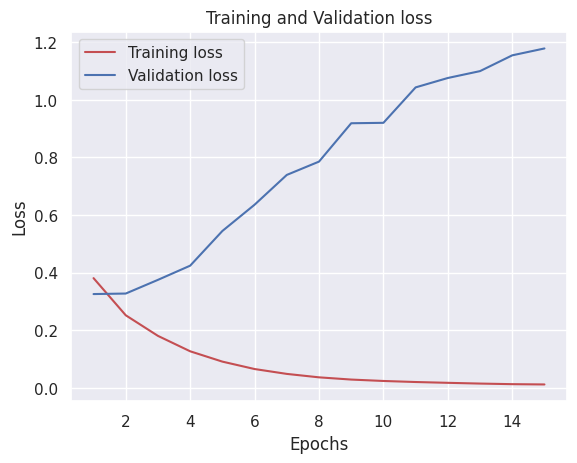

In [51]:

loss = history_dict_GRU['loss']
val_loss =history_dict_GRU['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss, 'r', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

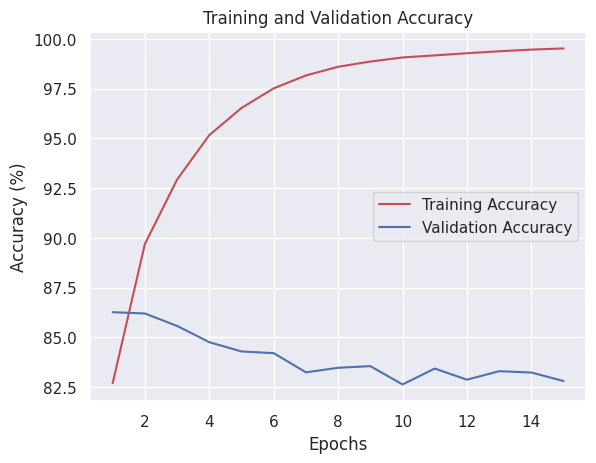

In [70]:
acc = [val *100 for val in history_dict_GRU['acc']]
val_acc = [val *100 for val in history_dict_GRU['val_acc']]

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Conclusion

 * LSTM와 GRU를 적용하여서 네이버 영화 리뷰 댓글 분석을 하였습니다
 * 두개의 모델은 거의 동일하게 초반에 학습이 완료 되었습니다
    - Training loss는 감소하고 급격하게 validation loss가 증가하는 부분은 3~4 epoch 였습니다.
    - 둘다 정확도는 85% 정도였습니다
